In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport
import scipy.stats as stats 
from scipy.stats import mode

# Suppress warnings
import warnings 
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score

# Machine learning models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb

# Visualization of feature importances
from yellowbrick.model_selection import FeatureImportances

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

In [3]:
df = pd.read_csv('../data/processed/train_cleaned.csv')
print('This dataset has %d rows dan %d columns.\n' % df.shape)
df.head()

This dataset has 100000 rows dan 27 columns.



,ID,Customer_ID,Month,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,23,821000265.000000,12,19114.120000,1824.843333,3.000000,4,3.000000,4.000000,135,3.000000,7.000000,11.270000,4.000000,2,809.980000,26.822620,265.000000,1,49.574949,80.415295,2,312.494089,Good
1,5635,3392,2,23,821000265.000000,12,19114.120000,1584.788750,3.000000,4,3.000000,4.000000,135,3.000000,5.000000,11.270000,4.000000,1,809.980000,31.944960,265.000000,1,49.574949,118.280222,3,284.629162,Good
2,5636,3392,3,14,821000265.000000,12,19114.120000,1583.388333,3.000000,4,3.000000,4.000000,135,3.000000,7.000000,9.270000,4.000000,1,809.980000,28.609352,267.000000,1,49.574949,81.699521,4,331.209863,Good
3,5637,3392,4,23,821000265.000000,12,19114.120000,1569.508750,3.000000,4,3.000000,4.000000,135,5.000000,4.000000,6.270000,4.000000,1,809.980000,31.377862,268.000000,1,49.574949,199.458074,5,223.451310,Good
4,5638,3392,5,23,821000265.000000,12,19114.120000,1824.843333,3.000000,4,3.000000,4.000000,135,6.000000,0.000000,11.270000,4.000000,1,809.980000,24.797347,269.000000,1,49.574949,41.420153,1,341.489231,Good


In [4]:
# Drop unecessary columns
df = df.drop(columns=['ID'])
df = df.drop(columns=['Customer_ID'])

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64


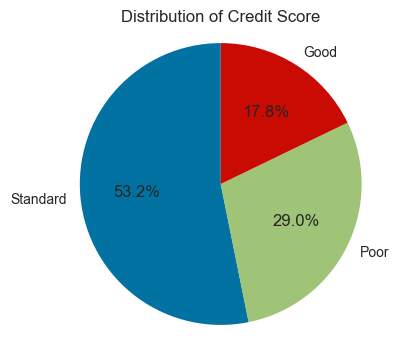

In [5]:
credit_score_counts = df['Credit_Score'].value_counts()
print(credit_score_counts)

plt.figure(figsize=(4, 4))
plt.pie(credit_score_counts, labels=credit_score_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Credit Score')
plt.axis('equal')  
plt.show()

In [6]:
df['Credit_Score'] = df['Credit_Score'].apply(lambda x: 'Good' if x in ['Good', 'Standard'] else x)

In [7]:
encoder = LabelEncoder()
df['Credit_Score'] = encoder.fit_transform(df['Credit_Score'])

In [8]:
credit_score= df['Credit_Score'].value_counts()
print(credit_score)

Credit_Score
0    71002
1    28998
Name: count, dtype: int64


In [9]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
print(f"Training set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")

Training set size: (80000, 25)
Validation set size: (20000, 25)


In [11]:
correlation_matrix = train_data.corr()
credit_score_correlation = correlation_matrix['Credit_Score'].sort_values(ascending=False)
print(credit_score_correlation)

Credit_Score                1.000000
Interest_Rate               0.388496
Delay_from_due_date         0.373055
Outstanding_Debt            0.362335
Num_Credit_Inquiries        0.360529
Num_Credit_Card             0.307525
Num_of_Loan                 0.297238
Num_Bank_Accounts           0.274634
Num_of_Delayed_Payment      0.247050
Payment_of_Min_Amount       0.173328
Payment_Behaviour           0.092889
Changed_Credit_Limit        0.064542
Occupation                  0.007025
Total_EMI_per_month         0.004137
Month                       0.003035
Type_of_Loan                0.001903
SSN                        -0.014357
Credit_Utilization_Ratio   -0.037611
Annual_Income              -0.071692
Amount_invested_monthly    -0.115742
Age                        -0.119590
Monthly_Inhand_Salary      -0.163885
Monthly_Balance            -0.165052
Credit_Mix                 -0.243897
Credit_History_Age         -0.327085
Name: Credit_Score, dtype: float64


In [12]:
X_train = train_data.drop(columns=['Credit_Score'])
y_train = train_data['Credit_Score']

In [19]:
X_val = val_data.drop(columns=['Credit_Score'])
y_val= val_data['Credit_Score']

Outstanding_Debt        0.146787
Interest_Rate           0.097434
Credit_History_Age      0.070834
Delay_from_due_date     0.064146
Num_Credit_Inquiries    0.054411
Changed_Credit_Limit    0.045714
Monthly_Inhand_Salary   0.037107
Annual_Income           0.036426
SSN                     0.035491
Monthly_Balance         0.034063
dtype: float64


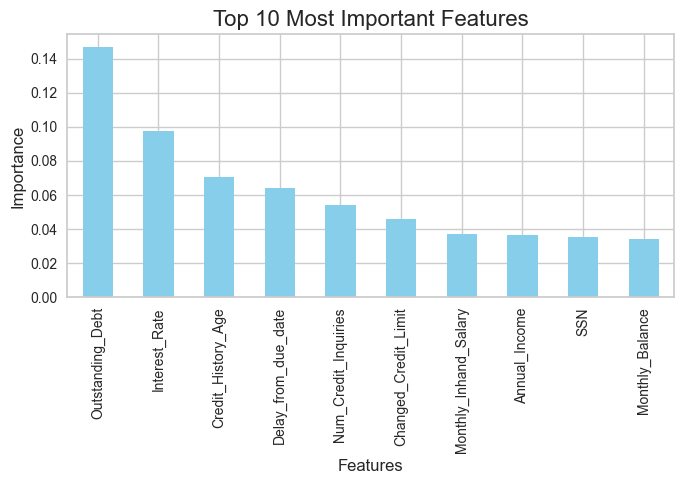

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the Random Forest model
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Get the top 10 features based on importance
top_10_features = feature_importances.sort_values(ascending=False).head(10)
print(top_10_features)

# Plot the top 10 features
top_10_features.plot(kind='bar', color='skyblue', figsize=(7, 5))
plt.title('Top 10 Most Important Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

Accuracy: 0.8786
Precision: 0.8113
Recall: 0.7644
F1-Score: 0.7872
ROC AUC: 0.9416
Confusion Matrix:
[[13082  1044]
 [ 1384  4490]]


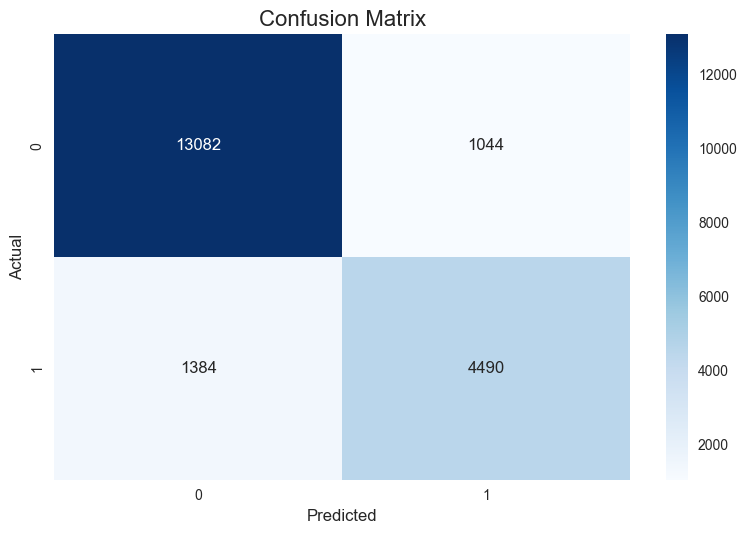


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14126
           1       0.81      0.76      0.79      5874

    accuracy                           0.88     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.88      0.88      0.88     20000



In [20]:
y_pred_rf = rf.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_rf)
precision = precision_score(y_val, y_pred_rf)
recall = recall_score(y_val, y_pred_rf)
f1 = f1_score(y_val, y_pred_rf)
roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))


In [14]:
negative_class_count = (y_train == 0).sum()
positive_class_count = (y_train == 1).sum()
scale_pos_weight = negative_class_count / positive_class_count

Top 10 Features:
Outstanding_Debt: 399.0
SSN: 338.0
Delay_from_due_date: 332.0
Type_of_Loan: 331.0
Interest_Rate: 326.0
Credit_History_Age: 315.0
Changed_Credit_Limit: 301.0
Monthly_Inhand_Salary: 296.0
Total_EMI_per_month: 294.0
Num_of_Delayed_Payment: 229.0


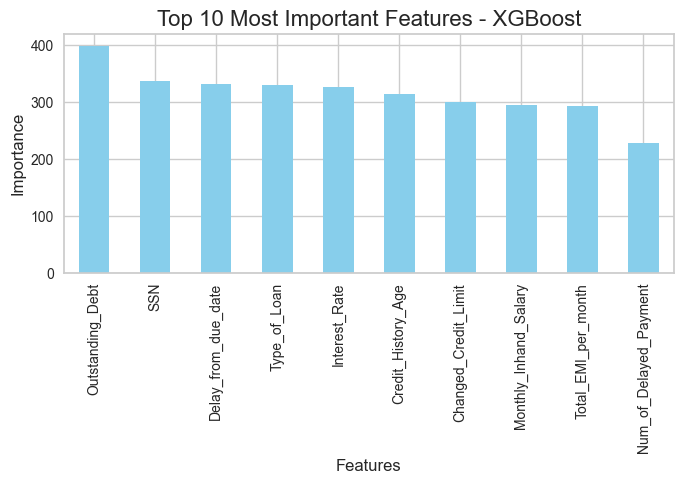

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'binary:logistic',  # Binary classification task
    'eval_metric': 'logloss',
    'tree_method': 'hist',  # Enable GPU-based tree learning
    'predictor': 'gpu_predictor',  # GPU predictor
    'gpu_id': 0,  # GPU 0 if multiple GPUs, change if necessary
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'scale_pos_weight': scale_pos_weight 
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Get feature importances
importance = xgb_model.get_score(importance_type='weight')

# Sort and extract the top 10 features
top_10_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 features
print("Top 10 Features:")
for feature, score in top_10_features:
    print(f"{feature}: {score}")

# Plot the top 10 features
top_features = pd.Series(dict(top_10_features))
top_features.plot(kind='bar', color='skyblue', figsize=(7, 5))
plt.title('Top 10 Most Important Features - XGBoost', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

Accuracy: 0.8234
Precision: 0.6622
Recall: 0.8134
F1-Score: 0.7301
ROC AUC: 0.8986
Confusion Matrix:
[[11689  2437]
 [ 1096  4778]]


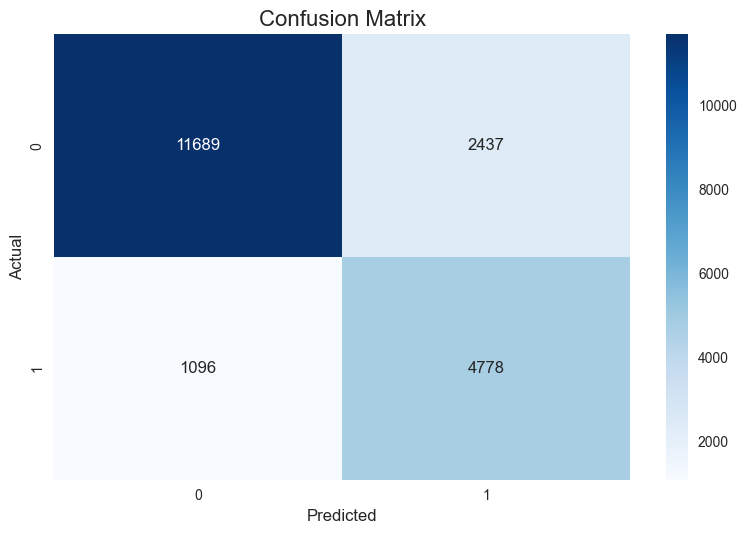


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     14126
           1       0.66      0.81      0.73      5874

    accuracy                           0.82     20000
   macro avg       0.79      0.82      0.80     20000
weighted avg       0.84      0.82      0.83     20000



In [21]:
dval = xgb.DMatrix(X_val)

# Predict with the XGBoost model
y_pred_xgb = xgb_model.predict(dval)
y_pred_xgb_binary = (y_pred_xgb > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_xgb_binary)
precision = precision_score(y_val, y_pred_xgb_binary)
recall = recall_score(y_val, y_pred_xgb_binary)
f1 = f1_score(y_val, y_pred_xgb_binary)
roc_auc = roc_auc_score(y_val, y_pred_xgb)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_xgb_binary)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb_binary))


In [16]:
selected_features = [
    'Outstanding_Debt', 
    'Interest_Rate', 
    'Delay_from_due_date', 
    'Monthly_Inhand_Salary', 
    'Num_Credit_Inquiries', 
    'Credit_History_Age', 
    'Changed_Credit_Limit', 
    'Num_of_Delayed_Payment', 
    'Type_of_Loan', 
    'Total_EMI_per_month'
]

In [17]:
df_selected = df[selected_features + ['Credit_Score']] 

df_selected.to_csv('../data/datasets_inter/train_features.csv', index=False)

print("Modified dataset saved as 'train_features.csv'.")

Modified dataset saved as 'train_features.csv'.


In [18]:
test_df = pd.read_csv('../data/processed/test_cleaned.csv')

test_df_selected = test_df[selected_features]

test_df_selected.to_csv('../data/datasets_inter/test_features.csv', index=False)

print("Test dataset saved as 'test_features.csv'.")

Test dataset saved as 'test_features.csv'.
